## Graphics for Membership Levels
### This can include plotting total active members, leave, temporary leave, revoked/suspended, etc

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy
import numpy as np
from datetime import datetime
from container_credentials import return_credentials

In [3]:
#connect to the database instance
cred_dict = return_credentials()

user = cred_dict['user'] 
password = cred_dict['pass'] 
host = cred_dict['host'] 
port = cred_dict['port'] 
database = cred_dict['database']

'''user = 'root'
password = 'baeldung'
host = '172.17.0.2'
port = 3306
database = 'membership'''

def get_connection():
	return sqlalchemy.create_engine(
		url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
			user, password, host, port, database
		)
	)

if __name__ == '__main__':

	try:
	
		# GET THE CONNECTION OBJECT (ENGINE) FOR THE DATABASE
		engine = get_connection()
		print(
			f"Connection to the {host} for user {user} created successfully.")
	except Exception as ex:
		print("Connection could not be made due to the following error: \n", ex)

Connection to the 172.17.0.2 for user root created successfully.


In [5]:
query = '''
SELECT calendar_date, 
SUM(CASE WHEN activity_calc IN ('winback','initial enrollment','technical activation','technical reactivation','technical re-activation') THEN 1 ELSE 0 END) AS active_cnts, 
SUM(CASE WHEN activity_calc IN ('parental leave','medical leave','care giving leave') THEN 1 ELSE 0 END) AS temporary_inactivte, 
SUM(CASE WHEN activity_calc IN ('cancelled','deactivated','deactive','suspended') THEN 1 ELSE 0 END) revoked,
SUM(CASE WHEN activity_calc IN ('general leave') THEN 1 ELSE 0 END) general_leave, 
SUM(CASE WHEN activity_calc IN ('winback') THEN 1 ELSE 0 END) winbacks
FROM stack_job2 sj
INNER JOIN calendar cal ON calendar_date between start_dt AND lead_date 
GROUP BY 1 
ORDER BY 1 desc
'''
from sqlalchemy import text

with engine.connect() as conn:
    df = pd.read_sql(query, con = conn)


In [6]:
df = df.assign(calendar_date = pd.to_datetime(df['calendar_date']))

In [7]:
#describe will tell me the high watermark for members
df.describe()

,calendar_date,active_cnts,temporary_inactivte,revoked,general_leave,winbacks
count,1797,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,2022-06-17 00:00:00,295.347802,9.063439,300.613244,183.301614,34.112966
min,2020-01-01 00:00:00,259.000000,3.000000,93.000000,47.000000,20.000000
25%,2021-03-25 00:00:00,280.000000,7.000000,195.000000,130.000000,31.000000
50%,2022-06-17 00:00:00,299.000000,9.000000,308.000000,194.000000,34.000000
75%,2023-09-09 00:00:00,308.000000,10.000000,409.000000,241.000000,38.000000
max,2024-12-01 00:00:00,336.000000,18.000000,492.000000,289.000000,46.000000
std,NaN,18.825592,2.931547,118.510292,66.398786,5.550340


In [8]:
#subtract winbacks from active_cnts in order to plot the regions on the stacked bar chart
df=df.assign(active_non_win = df['active_cnts'] - df['winbacks'])

In [9]:
#weekly snapshots is sufficient (intervals set to 7)
df2 = df.sort_values('calendar_date').iloc[::7]

In [10]:
#pull stats on the last measurement date
print(df.iloc[0].to_dict())
print(df.iloc[7].to_dict())
print(df.iloc[16].to_dict())
print(df.iloc[26].to_dict())
print(df.iloc[36].to_dict())
print(df.iloc[45].to_dict())
print(df.iloc[52].to_dict())

{'calendar_date': Timestamp('2024-12-01 00:00:00'), 'active_cnts': 325.0, 'temporary_inactivte': 18.0, 'revoked': 488.0, 'general_leave': 289.0, 'winbacks': 46.0, 'active_non_win': 279.0}
{'calendar_date': Timestamp('2024-11-24 00:00:00'), 'active_cnts': 322.0, 'temporary_inactivte': 18.0, 'revoked': 488.0, 'general_leave': 289.0, 'winbacks': 46.0, 'active_non_win': 276.0}
{'calendar_date': Timestamp('2024-11-15 00:00:00'), 'active_cnts': 315.0, 'temporary_inactivte': 18.0, 'revoked': 491.0, 'general_leave': 287.0, 'winbacks': 43.0, 'active_non_win': 272.0}
{'calendar_date': Timestamp('2024-11-05 00:00:00'), 'active_cnts': 313.0, 'temporary_inactivte': 15.0, 'revoked': 488.0, 'general_leave': 284.0, 'winbacks': 44.0, 'active_non_win': 269.0}
{'calendar_date': Timestamp('2024-10-26 00:00:00'), 'active_cnts': 317.0, 'temporary_inactivte': 15.0, 'revoked': 485.0, 'general_leave': 282.0, 'winbacks': 45.0, 'active_non_win': 272.0}
{'calendar_date': Timestamp('2024-10-17 00:00:00'), 'active_

In [18]:
from datetime import timedelta
graph_values = df.iloc[0,:]

#print the max/high-water-mark of membership
max_value = df['active_cnts'].max()

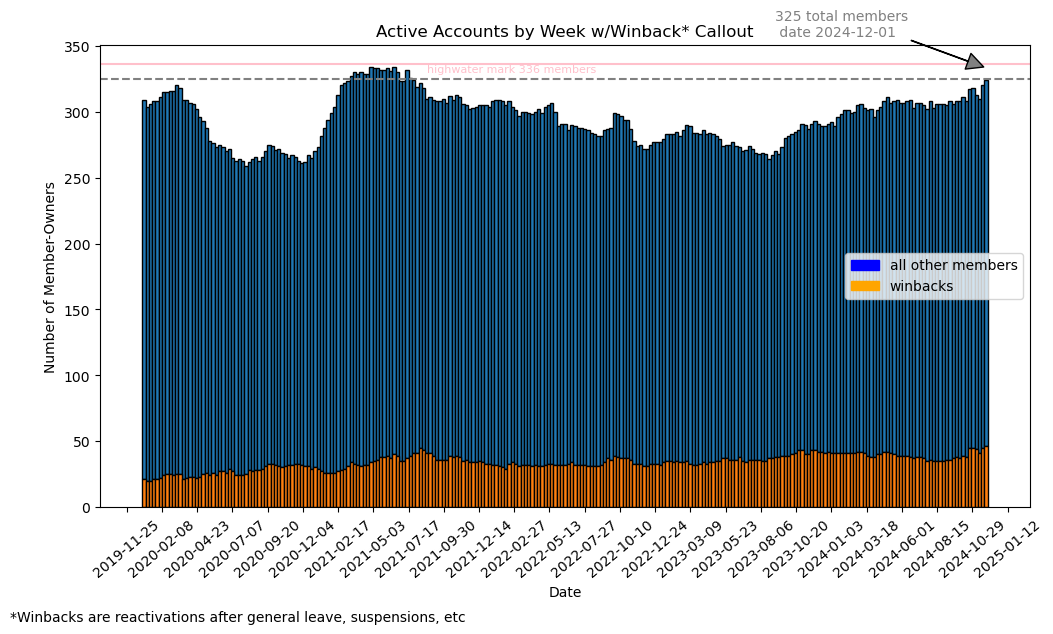

In [23]:
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker 
#the two ahlines coincide w/the high water mark of member-owners and the most recent level (graph_values)

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(df2['calendar_date'],df2['active_non_win'],bottom=df2['winbacks'], width=7, edgecolor = 'black')
ax.bar(df2['calendar_date'],df2['winbacks'], width=7, edgecolor = 'black')
ax.set_title("Active Accounts by Week w/Winback* Callout")
ax.tick_params(axis='x', labelrotation = 40)
ax.axhline(y=max_value,linestyle = '-', color = 'pink')
ax.axhline(y=graph_values['active_cnts'],linestyle = '--', color = 'grey')
ax.set_ylabel('Number of Member-Owners')
ax.legend(['winbacks', 'all other members'])
#create 'artists' for the legend
blue_patch = mpatches.Patch(color='blue', label='all other members')
orange_patch = mpatches.Patch(color='orange', label='winbacks')
ax.legend(handles=[blue_patch,orange_patch], loc = 'center right')
ax.set_xlabel("Date")
ax.text(datetime(2021,8,25),330,f'highwater mark {int(max_value)} members',fontsize=8,color='pink')

ax.annotate(f'{int(graph_values['active_cnts'])} total members\n date {datetime.strftime(graph_values['calendar_date'],'%Y-%m-%d')}', xy=(graph_values['calendar_date'] - timedelta(days = 9), graph_values['active_cnts']+9), xycoords='data',
            xytext=(-150, 22), color='grey',textcoords='offset points',arrowprops=dict(facecolor='grey',width=0.25))
space = 75
ax.xaxis.set_major_locator(ticker.MultipleLocator(space)) 

#centering xtick labels (middle of text to coincide w/tick)
for label in ax.get_xticklabels(which='major'):
    label.set(horizontalalignment='center')

plt.figtext(0.05,-.08,'*Winbacks are reactivations after general leave, suspensions, etc')

plt.show()


### Trial tracking

In [33]:
query = '''
select date_format(start_dt, "%Y-%m") as month, count(distinct email) as count
from consolidated_mem_type
where type_clean like '%trial%'
AND start_dt > DATE("2019-06-01")
group by 1
order by 1 desc'''

from sqlalchemy import text

with engine.connect() as conn:
    df3 = pd.read_sql(text(query), con = conn)

In [34]:
df3.head()

,month,count
0,2024-11,45
1,2024-10,43
2,2024-09,77
3,2024-08,42
4,2024-07,42


In [35]:
df3 = df3.assign(calendar_mo = pd.to_datetime(df3['month'], format = "%Y-%m"))

In [37]:
df3.head()

,month,count,calendar_mo
0,2024-11,45,2024-11-01
1,2024-10,43,2024-10-01
2,2024-09,77,2024-09-01
3,2024-08,42,2024-08-01
4,2024-07,42,2024-07-01


In [44]:
#pd.strftime(df3['calendar_mo'], format = '%Y-%m')
df3['calendar_mo'].dt.strftime('%Y-%m')

0     2024-11
1     2024-10
2     2024-09
3     2024-08
4     2024-07
       ...   
61    2019-10
62    2019-09
63    2019-08
64    2019-07
65    2019-06
Name: calendar_mo, Length: 66, dtype: object

In [48]:
?plt.ax.set_xticklabels

Object `plt.ax.set_xticklabels` not found.


/tmp/ipykernel_29163/592095113.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df3['calendar_mo'].dt.strftime('%Y-%m'))


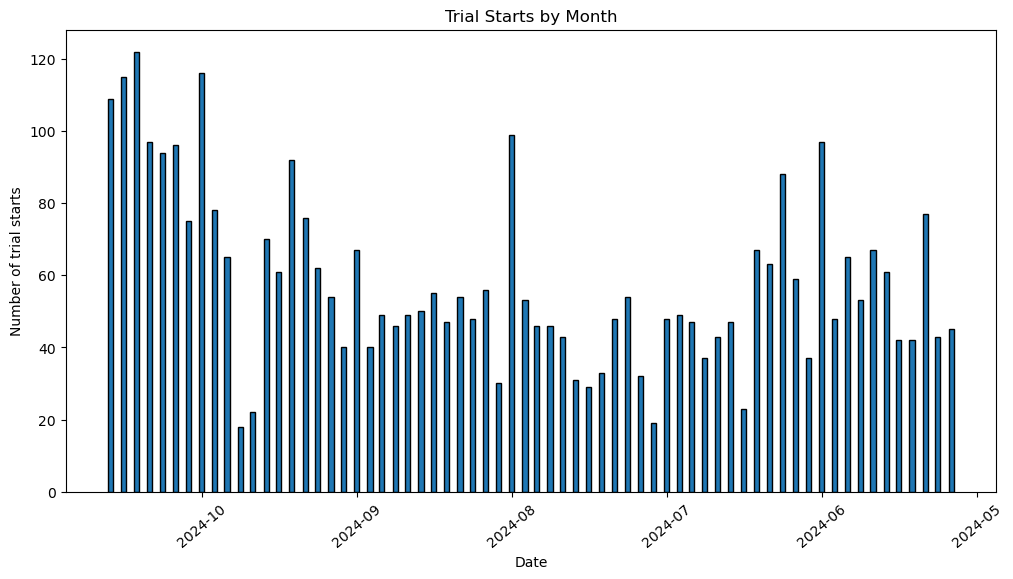

In [47]:
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker 

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(df3['calendar_mo'],df3['count'], width = 12, edgecolor = 'black')
ax.set_title("Trial Starts by Month")
ax.tick_params(axis='x', labelrotation = 40)
ax.set_xticklabels(df3['calendar_mo'].dt.strftime('%Y-%m'))
ax.set_ylabel('Number of trial starts')
ax.set_xlabel("Date")

'''
ax.xaxis.set_major_locator(ticker.MultipleLocator(space)) 

#centering xtick labels (middle of text to coincide w/tick)
for label in ax.get_xticklabels(which='major'):
    label.set(horizontalalignment='center')
'''
plt.show()